# Data preprocessing

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.datatypes import convert_to
from sktime.datatypes._panel._convert import (
    from_3d_numpy_to_nested,
    from_3d_numpy_to_multi_index
)

%matplotlib inline

## Load the dataset

In [6]:
data_path = "../data/Predictive-Maintenance-Of-Hydraulics-System/"

In [8]:
fs1 = np.loadtxt((data_path+'FS1.txt'), delimiter='\t')
fs1.shape

(2205, 600)

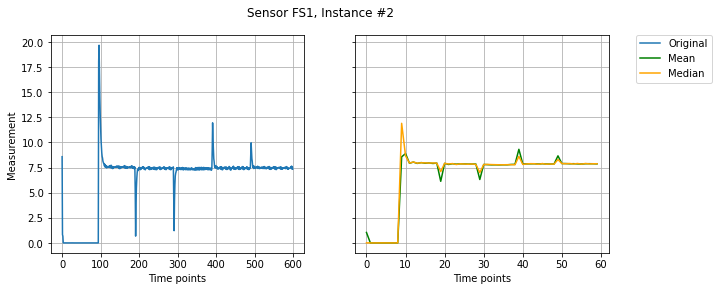

In [401]:
INSTANCE_NR = 2

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
for ax in ax1, ax2:
    ax.grid(True)

ax1.plot(fs1[1100], label="Original")
ax1.set_xlabel('Time points')
ax1.set_ylabel('Measurement')


avg = np.mean(fs1[INSTANCE_NR].reshape(60,10), axis=1)
med = np.median(fs1[INSTANCE_NR].reshape(60,10), axis=1)

ax2.plot(avg, label='Mean', color='green')
ax2.plot(med, label='Median', color='orange')
fig.suptitle(f'Sensor FS1, Instance #{INSTANCE_NR}')
ax2.set_xlabel('Time points')

fig.legend(bbox_to_anchor=(1.05, 0.9))
plt.show()

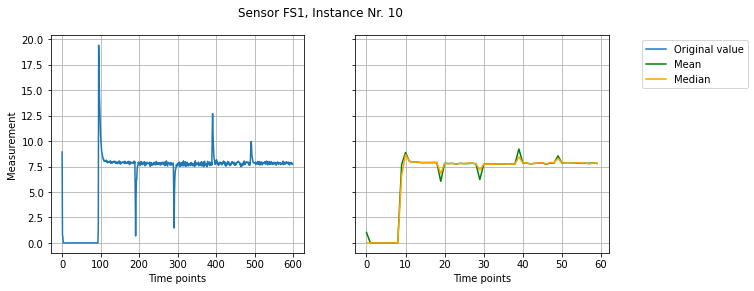

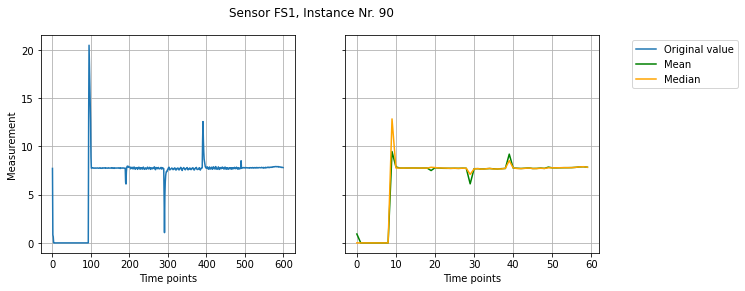

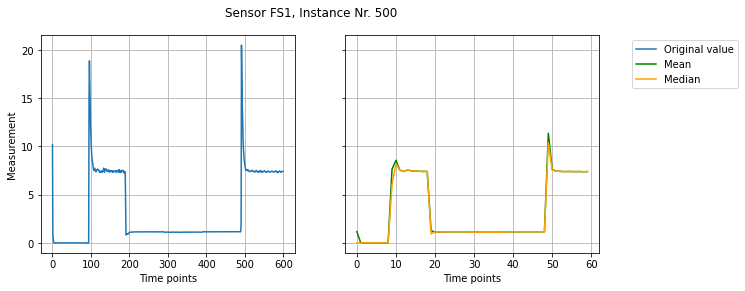

In [432]:
def plot_samples(file_name, instances=[0,1,2]):
    data = np.loadtxt((data_path+file_name), delimiter='\t')
    sensor_name = file_name.split('.')[0]
    
    for INSTANCE_NR in instances:
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
        for ax in ax1, ax2:
            ax.grid(True)

        ax1.plot(data[INSTANCE_NR], label="Original value")
        ax1.set_xlabel('Time points')
        ax1.set_ylabel('Measurement')


        avg = np.mean(data[INSTANCE_NR].reshape(60,10), axis=1)
        med = np.median(data[INSTANCE_NR].reshape(60,10), axis=1)

        ax2.plot(avg, label='Mean', color='green')
        ax2.plot(med, label='Median', color='orange')
        fig.suptitle(f'Sensor {sensor_name}, Instance Nr. {INSTANCE_NR}')
        ax2.set_xlabel('Time points')

        fig.legend(bbox_to_anchor=(1.1, 0.88))
        plt.show()

plot_samples('FS1.txt', [10, 90, 500])

## Data preprocessing

In [267]:
def read_data(file_path, delimiter='\t'):
    return np.loadtxt(file_path, delimiter=delimiter)

def reshape_data(data, new_len):
    return data.reshape(data.shape[0], new_len, int(data.shape[1]/new_len))

def calc_mean(data, axis=2):
    return np.mean(data, axis=axis)

In [ ]:
import glob 
import os

data_path = "../data/Predictive-Maintenance-Of-Hydraulics-System/"
file_names = []

for file_name_relative in glob.glob(data_path + "**/*.txt",recursive=True):
    file_name_absolute = os.path.basename(file_name_relative)
    file_names.append(file_name_absolute)
    
    # print("File name: ", file_name_absolute)

In [276]:
file_names.remove('description.txt')
file_names.remove('profile.txt')
file_names.remove('documentation.txt')

print(file_names)

['TS4.txt', 'TS1.txt', 'TS2.txt', 'PS6.txt', 'PS1.txt', 'PS5.txt', 'SE.txt', 'PS3.txt', 'TS3.txt', 'VS1.txt', 'CP.txt', 'CE.txt', 'PS4.txt', 'FS2.txt', 'FS1.txt', 'PS2.txt', 'EPS1.txt']


In [323]:
%%time

MIN_LENGTH = 60
stacked = None

for file_name in file_names:
    data = read_data((data_path + file_name))
    if data.shape[1] > MIN_LENGTH:
        data = reshape_data(data, MIN_LENGTH)
    else:
        data = reshape_data(data, 1)
    
    if data.shape[1] > 1:
        data = calc_mean(data)
        data = reshape_data(data, 1)
    
    if stacked is None:
        stacked = data
    else:
        stacked = np.column_stack((stacked, data))

stacked.shape

CPU times: user 1min 3s, sys: 8.26 s, total: 1min 11s
Wall time: 1min 11s


(2205, 17, 60)

## Save the numpy3D file

In [325]:
with open(data_path + 'preprocessed.npy', 'wb') as f:
    np.save(f, stacked)

## Convert the numpy3D into pandas multiindex dataframe

In [329]:
stacked.shape

(2205, 17, 60)

In [331]:
df = convert_to(stacked, to_type="pd-multiindex")
df.head()

var_0   var_1   var_2    var_3     var_4    var_5  \
instances timepoints                                                       
0         0           30.363  35.570  40.961  9.84138  176.8996  9.96442   
          1           30.375  35.492  40.949  9.83686  184.6420  9.95969   
          2           30.367  35.469  40.965  9.83819  189.8996  9.96422   
          3           30.367  35.422  40.922  9.84618  191.3442  9.96867   
          4           30.379  35.414  40.879  9.84887  191.2833  9.97288   

                       var_6    var_7   var_8  var_9  var_10  var_11  var_12  \
instances timepoints                                                           
0         0           68.039  0.18954  38.320  0.604   2.184  47.202     0.0   
          1            0.000  0.00000  38.332  0.605   2.184  47.273     0.0   
          2            0.000  0.00000  38.320  0.611   2.184  47.250     0.0   
          3            0.000  0.00000  38.324  0.603   2.185  47.332     0.0   
          4            0.000  0.00000  38.332  0.608   2.178  47.213     0.0   

                       var_13  var_14    var_15    var_16  
instances timepoints                                       
0         0           10.1691  1.0413  11.86685  2613.468  
          1           10.1704  0.0007   0.18786  2917.282  
          2           10.1641  0.0023   0.02133  2861.840  
          3           10.1751  0.0008   0.00283  2946.474  
          4           10.1730  0.0014   0.00000  2946.164

## Save the dataset as csv file

In [337]:
file_names_2 = list(map(lambda x: x.split('.')[0], file_names))
df.columns = file_names_2

In [338]:
df.head()

TS4     TS1     TS2      PS6       PS1      PS5  \
instances timepoints                                                       
0         0           30.363  35.570  40.961  9.84138  176.8996  9.96442   
          1           30.375  35.492  40.949  9.83686  184.6420  9.95969   
          2           30.367  35.469  40.965  9.83819  189.8996  9.96422   
          3           30.367  35.422  40.922  9.84618  191.3442  9.96867   
          4           30.379  35.414  40.879  9.84887  191.2833  9.97288   

                          SE      PS3     TS3    VS1     CP      CE  PS4  \
instances timepoints                                                       
0         0           68.039  0.18954  38.320  0.604  2.184  47.202  0.0   
          1            0.000  0.00000  38.332  0.605  2.184  47.273  0.0   
          2            0.000  0.00000  38.320  0.611  2.184  47.250  0.0   
          3            0.000  0.00000  38.324  0.603  2.185  47.332  0.0   
          4            0.000  0.00000  38.332  0.608  2.178  47.213  0.0   

                          FS2     FS1       PS2      EPS1  
instances timepoints                                       
0         0           10.1691  1.0413  11.86685  2613.468  
          1           10.1704  0.0007   0.18786  2917.282  
          2           10.1641  0.0023   0.02133  2861.840  
          3           10.1751  0.0008   0.00283  2946.474  
          4           10.1730  0.0014   0.00000  2946.164

In [339]:
df.to_csv(data_path + 'preprocessed.csv')

## Read multiindex csv file into a pandas dataframe

In [341]:
# Check out if it works properly
df2 = pd.read_csv(data_path + 'preprocessed.csv', index_col=[0,1])
df2.head()

TS4     TS1     TS2      PS6       PS1      PS5  \
instances timepoints                                                       
0         0           30.363  35.570  40.961  9.84138  176.8996  9.96442   
          1           30.375  35.492  40.949  9.83686  184.6420  9.95969   
          2           30.367  35.469  40.965  9.83819  189.8996  9.96422   
          3           30.367  35.422  40.922  9.84618  191.3442  9.96867   
          4           30.379  35.414  40.879  9.84887  191.2833  9.97288   

                          SE      PS3     TS3    VS1     CP      CE  PS4  \
instances timepoints                                                       
0         0           68.039  0.18954  38.320  0.604  2.184  47.202  0.0   
          1            0.000  0.00000  38.332  0.605  2.184  47.273  0.0   
          2            0.000  0.00000  38.320  0.611  2.184  47.250  0.0   
          3            0.000  0.00000  38.324  0.603  2.185  47.332  0.0   
          4            0.000  0.00000  38.332  0.608  2.178  47.213  0.0   

                          FS2     FS1       PS2      EPS1  
instances timepoints                                       
0         0           10.1691  1.0413  11.86685  2613.468  
          1           10.1704  0.0007   0.18786  2917.282  
          2           10.1641  0.0023   0.02133  2861.840  
          3           10.1751  0.0008   0.00283  2946.474  
          4           10.1730  0.0014   0.00000  2946.164

## Save the target variables into csv file

In [352]:
target_columns = ['target_cooler_condition', 'target_valve_condition', 'target_internal_pump_leakage', 
                  'target_hydraulic_accumulator_pressure', 'target_stable_flag']

profile = np.loadtxt((data_path + 'profile.txt'), delimiter='\t')
profile = profile.astype(int)
profile = profile.astype(str)

profile = pd.DataFrame(profile, columns=target_columns)

profile.head()

,target_cooler_condition,target_valve_condition,target_internal_pump_leakage,target_hydraulic_accumulator_pressure,target_stable_flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1


In [353]:
profile.to_csv(data_path + 'profile_targets.csv', index=False)